In [17]:
pip install pyathena

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pyathena in c:\users\karanveer\appdata\local\programs\python\python313\lib\site-packages (3.12.2)




[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install boto3 pandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import boto3
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Athena + S3 Configuration

In [5]:
ATHENA_DATABASE = 'kafka-stock-database'
ATHENA_OUTPUT = 's3://stock-athena-query-bucket/'
REGION_NAME = 'ap-south-1'

# Initialize Athena client

In [6]:
client = boto3.client('athena', region_name=REGION_NAME)

# SQL QUERY

In [13]:
query = '''
SELECT index, COUNT(*) AS count
FROM kafka_stock_project_karan
GROUP BY index
ORDER BY count DESC
LIMIT 10;
'''

       index  count
0       N225     45
1        NYA     41
2     GSPTSE     34
3       IXIC     30
4      GDAXI     28
5       TWII     20
6        HSI     20
7  399001.SZ     15
8       SSMI     15
9       N100     13


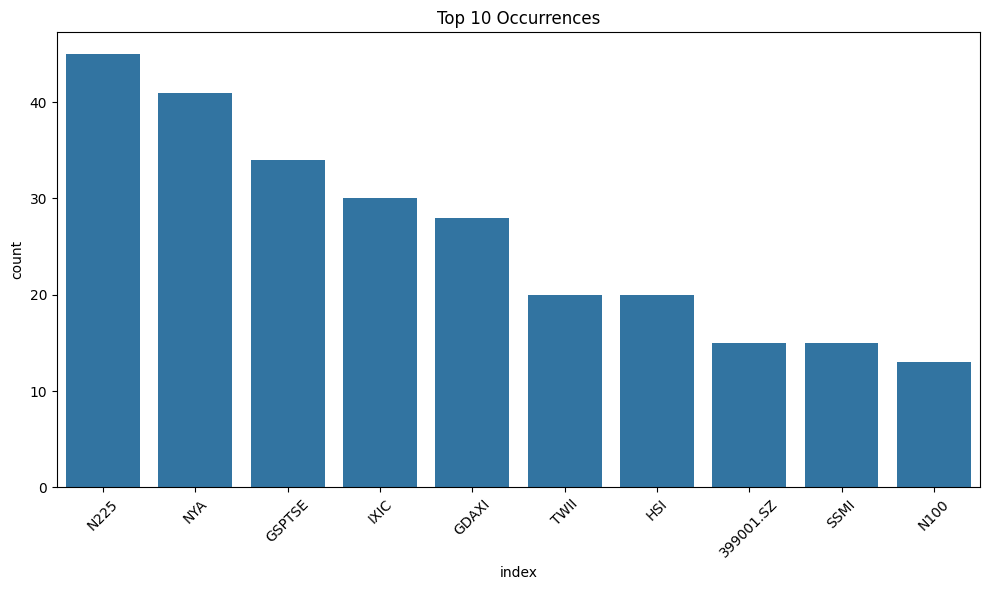

In [16]:
# Function to run Athena query and wait for result
def run_athena_query(query, database, output):
    response = client.start_query_execution(
        QueryString=query,
        QueryExecutionContext={'Database': database},
        ResultConfiguration={'OutputLocation': output}
    )

    query_execution_id = response['QueryExecutionId']

    # Wait for query to complete
    while True:
        status = client.get_query_execution(QueryExecutionId=query_execution_id)
        state = status['QueryExecution']['Status']['State']
        if state in ['SUCCEEDED', 'FAILED', 'CANCELLED']:
            break
        time.sleep(2)

    if state != 'SUCCEEDED':
        reason = status['QueryExecution']['Status'].get('StateChangeReason', 'No reason provided')
        raise Exception(f'Athena query failed with status: {state}\nReason: {reason}')

    return query_execution_id

# Function to download results into pandas DataFrame
def get_query_results(query_execution_id):
    result_file = f"{ATHENA_OUTPUT}{query_execution_id}.csv"
    df = pd.read_csv(result_file)
    return df

# Run query and get data
query_execution_id = run_athena_query(query, ATHENA_DATABASE, ATHENA_OUTPUT)
# Optional: wait a few seconds before trying to read CSV
time.sleep(5)
results_csv = f"{ATHENA_OUTPUT}{query_execution_id}.csv"

# Use pandas to load from S3 (using awswrangler or s3fs if needed)
import s3fs
fs = s3fs.S3FileSystem()
with fs.open(results_csv, 'rb') as f:
    df = pd.read_csv(f)

# Show the dataframe
print(df)

# Plotting the results
plt.figure(figsize=(10,6))
sns.barplot(x='index', y='count', data=df)
plt.xticks(rotation=45)
plt.title('Top 10 Occurrences')
plt.tight_layout()
plt.show()

In [20]:
# from pyathena import connect
# import pandas as pd
# import matplotlib.pyplot as plt

# # Athena + S3 connection
# s3_output = "s3://stock-athena-query-bucket/"
# conn = connect(s3_staging_dir=s3_output, region_name='ap-south-1')

# # Example query
# query = """
# SELECT index, volume, date
# FROM kafka_stock_project_karan
# WHERE index = 'N225'
# ORDER BY date DESC
# LIMIT 100
# """

# df = pd.read_sql(query, conn)
# df['date'] = pd.to_datetime(df['date'])

# # Plotting
# plt.figure(figsize=(12, 6))
# plt.plot(df['date'], df['volume'], marker='o')
# plt.title("N225 Stock Volume Over Time")
# plt.xlabel("Date")
# plt.ylabel("Volume")
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()